In [14]:
# 1. Library Imports

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
import tensorflow as tf
from pmdarima import auto_arima

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


In [15]:
plt.style.use("ggplot")

# 2. Data Collection
ticker = "AAPL"
df = yf.download(ticker, start="2018-01-01", end="2023-12-31")
df.dropna(inplace=True)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2018-01-02,40.479843,40.489245,39.774865,39.986361,102223600
1,2018-01-03,40.472786,41.017971,40.409341,40.543284,118071600
2,2018-01-04,40.660770,40.764168,40.437528,40.545623,89738400
3,2018-01-05,41.123718,41.210664,40.665483,40.757130,94640000
4,2018-01-08,40.970978,41.267067,40.872278,40.970978,82271200


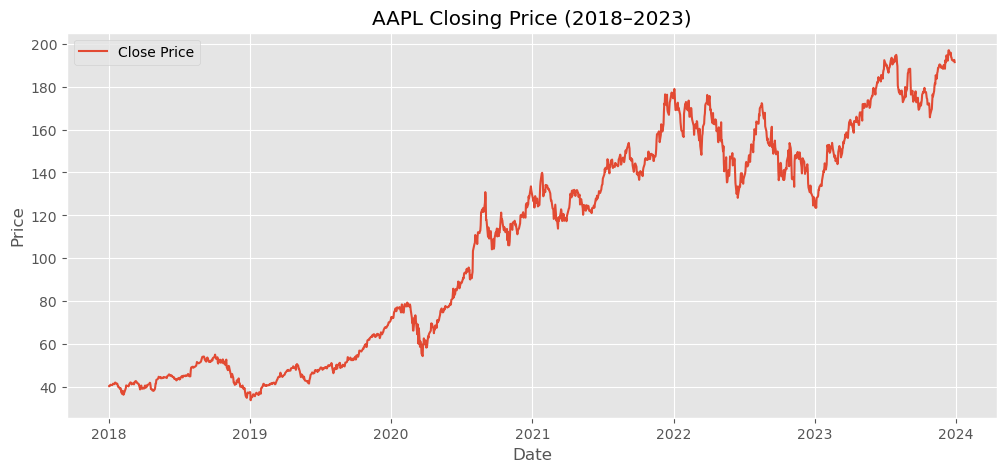

In [4]:
# 3. Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label="Close Price")
plt.title(f"{ticker} Closing Price (2018–2023)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [5]:
df.describe()

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
count,1509,1509.000000,1509.000000,1509.000000,1509.000000,1.509000e+03
mean,2020-12-30 14:13:07.276342016,108.193114,109.324611,106.948717,108.092817,1.073273e+08
min,2018-01-02 00:00:00,33.915253,34.757230,33.869933,34.342203,2.404830e+07
25%,2019-07-03 00:00:00,51.412636,52.218401,51.032326,51.550494,7.078370e+07
50%,2020-12-30 00:00:00,120.876663,122.135017,119.372411,121.017926,9.296430e+07
75%,2022-06-30 00:00:00,150.734467,152.492157,148.730111,150.559459,1.280440e+08
max,2023-12-29 00:00:00,196.927673,198.428656,195.824294,196.838214,4.265100e+08
std,NaN,51.108264,51.583687,50.578923,51.067150,5.513331e+07


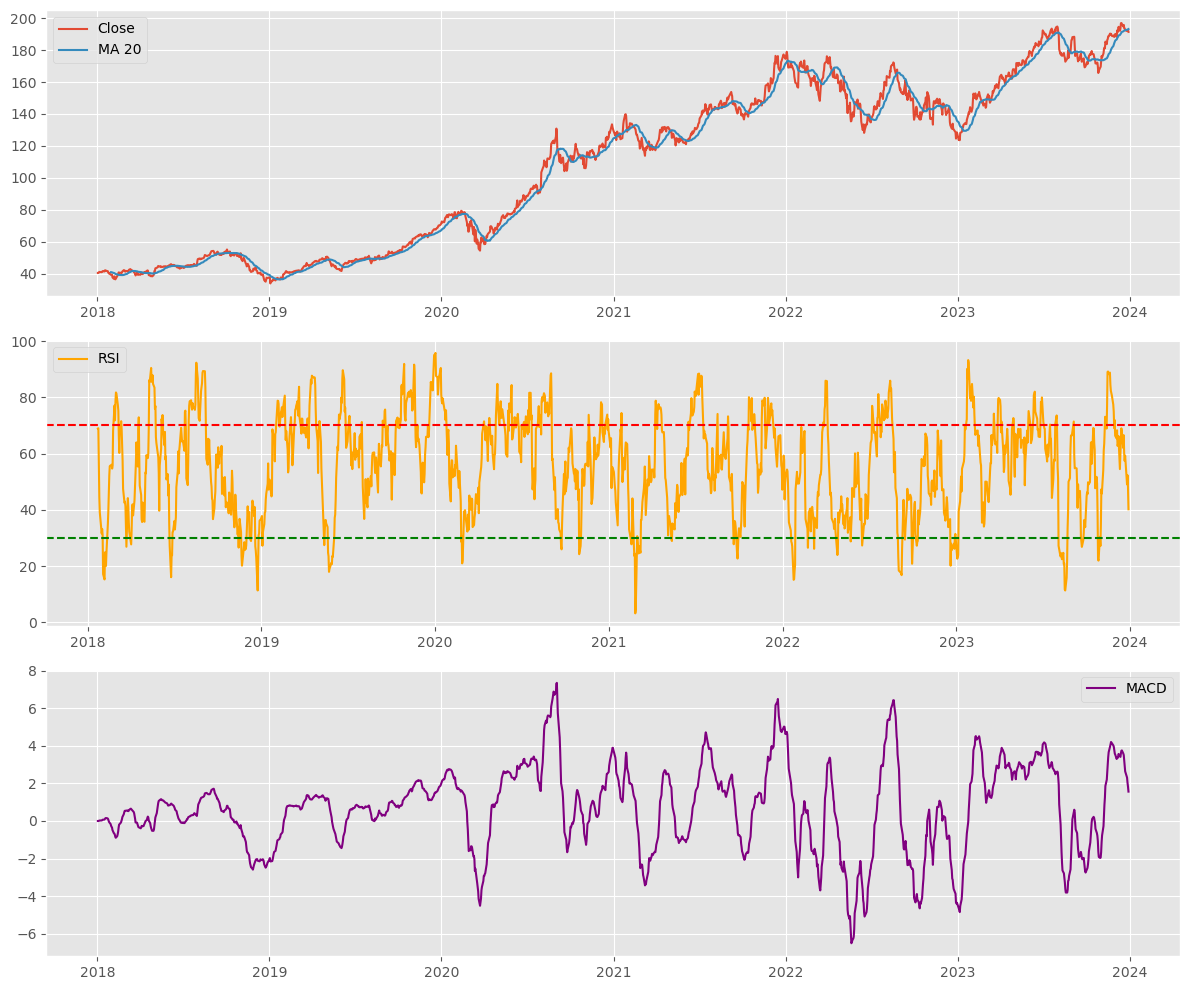

In [6]:
# 4. Feature Engineering
df['MA_20'] = df['Close'].rolling(window=20).mean()
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0).rolling(14).mean()
loss = -delta.where(delta < 0, 0).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
scaler = MinMaxScaler()
df['Close_Scaled'] = scaler.fit_transform(df[['Close']])

# Indicator Plots
fig, axs = plt.subplots(3, 1, figsize=(12, 10))
axs[0].plot(df['Date'], df['Close'], label="Close")
axs[0].plot(df['Date'], df['MA_20'], label="MA 20")
axs[0].legend()
axs[1].plot(df['Date'], df['RSI'], color='orange', label="RSI")
axs[1].axhline(70, color='red', linestyle='--')
axs[1].axhline(30, color='green', linestyle='--')
axs[1].legend()
axs[2].plot(df['Date'], df['MACD'], color='purple', label="MACD")
axs[2].legend()
plt.tight_layout()
plt.show()

In [7]:
# 5. Train-Test Split
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]
print(f"Train size: {len(train)} | Test size: {len(test)}")

Train size: 1207 | Test size: 302


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5209.692, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5213.042, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5210.017, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5209.839, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5212.928, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5213.296, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5213.296, Time=0.26 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5209.216, Time=1.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5214.198, Time=0.53 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5210.779, Time=1.14 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5210.958, Time=1.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5213.957, Time=0.72 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=5215.132, Time=0.53 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5212.830, Time=1.45 sec
 ARIMA(3,1,2)(0,0,0)[0]          

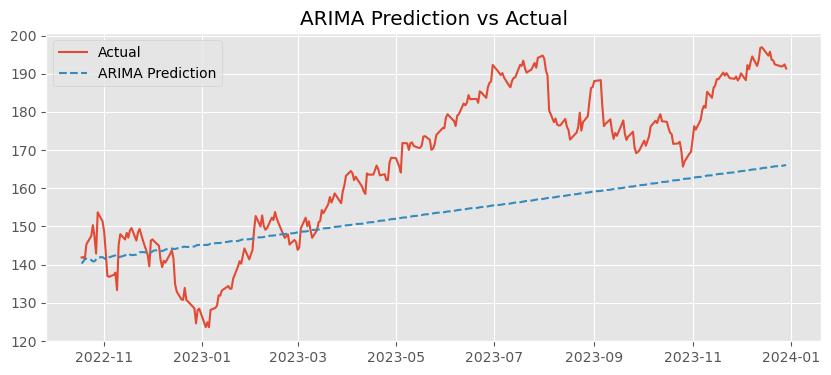

In [8]:
# 6. Model 1: ARIMA
arima_model = auto_arima(train['Close'], seasonal=False, trace=True, suppress_warnings=True)
arima_preds = arima_model.predict(n_periods=len(test))

# Evaluation Function
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} → MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return mae, rmse, r2

arima_mae, arima_rmse, arima_r2 = evaluate(test['Close'], arima_preds, "ARIMA")

plt.figure(figsize=(10, 4))
plt.plot(test['Date'], test['Close'], label='Actual')
plt.plot(test['Date'], arima_preds, label='ARIMA Prediction', linestyle='--')
plt.legend()
plt.title("ARIMA Prediction vs Actual")
plt.show()

02:15:32 - cmdstanpy - INFO - Chain [1] start processing
02:15:32 - cmdstanpy - INFO - Chain [1] done processing


Prophet → MAE: 22.58, RMSE: 25.61, R²: -0.71


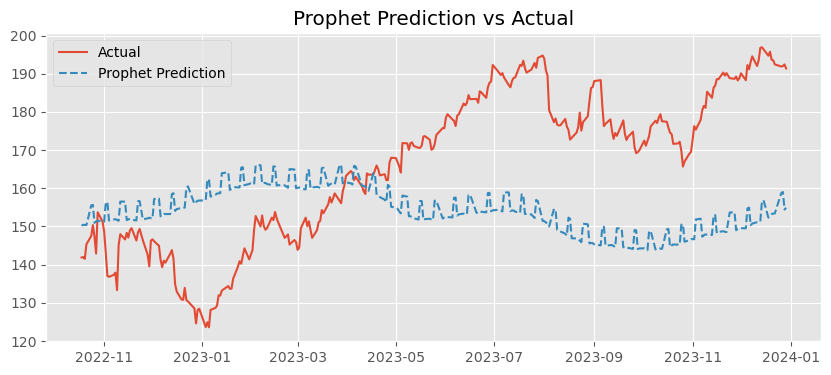

In [9]:
# 7. Model 2: Prophet
prophet_df = df[['Date', 'Close']].copy()
prophet_df.columns = ['ds', 'y']
prophet_df.dropna(inplace=True)

prophet = Prophet()
prophet.fit(prophet_df.iloc[:train_size])

future = prophet.make_future_dataframe(periods=len(test))
forecast = prophet.predict(future)
prophet_preds = forecast['yhat'][-len(test):].values

prophet_mae, prophet_rmse, prophet_r2 = evaluate(test['Close'], prophet_preds, "Prophet")

plt.figure(figsize=(10, 4))
plt.plot(test['Date'], test['Close'], label='Actual')
plt.plot(test['Date'], prophet_preds, label='Prophet Prediction', linestyle='--')
plt.legend()
plt.title("Prophet Prediction vs Actual")
plt.show()


Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0608
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.3748e-04
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.6247e-04
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7019e-04
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.8294e-04
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.7294e-04
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.7155e-04
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6179e-04
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.7982e-04
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.1895e-04
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 7.5540e-04
Epoch 13/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 6.6806e-04
Epoch 14/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 6.5626e-04
Epoch 15/30
36/36 ━━━━━

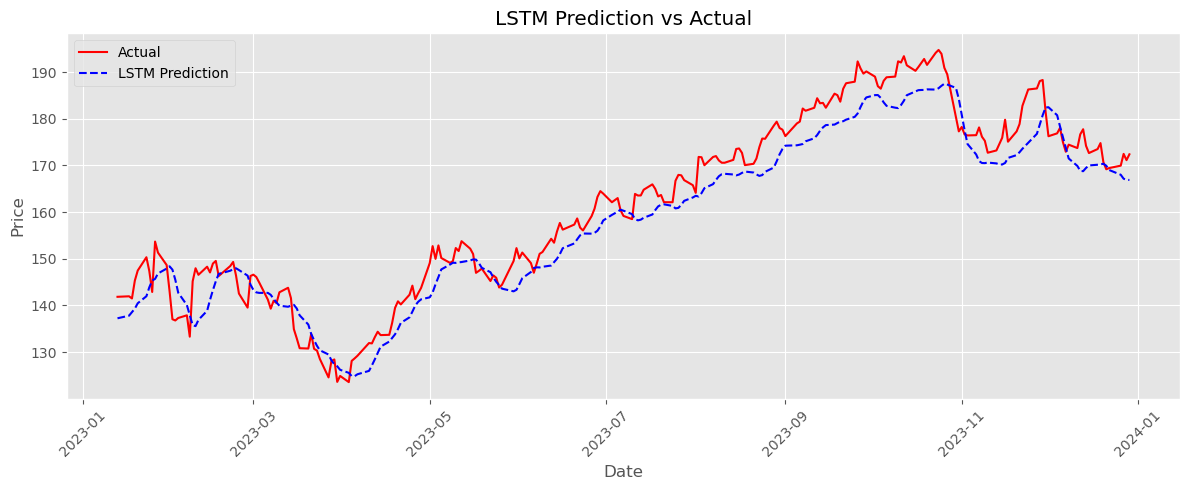

In [10]:
# 8. Model 3: LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

scaled_data = df['Close_Scaled'].values.reshape(-1, 1)
X_all, y_all = create_dataset(scaled_data)
split_index = int(train_size - 60)
X_train, y_train = X_all[:split_index], y_all[:split_index]
X_test, y_test = X_all[split_index:], y_all[split_index:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(60, 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

lstm_preds = model.predict(X_test)
lstm_preds_rescaled = scaler.inverse_transform(lstm_preds)
actual_lstm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

lstm_mae, lstm_rmse, lstm_r2 = evaluate(actual_lstm, lstm_preds_rescaled.flatten(), "LSTM")

actual_dates = df['Date'].iloc[train_size + 60:]

# Align lengths for plotting
min_len = min(len(actual_dates), len(actual_lstm), len(lstm_preds_rescaled.flatten()))

# Trim all to min_len
actual_dates_plot = actual_dates[:min_len]
actual_lstm_plot = actual_lstm[:min_len]
lstm_preds_plot = lstm_preds_rescaled.flatten()[:min_len]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(actual_dates_plot, actual_lstm_plot, label="Actual", color="red")
plt.plot(actual_dates_plot, lstm_preds_plot, label="LSTM Prediction", linestyle="--", color="blue")
plt.title("LSTM Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


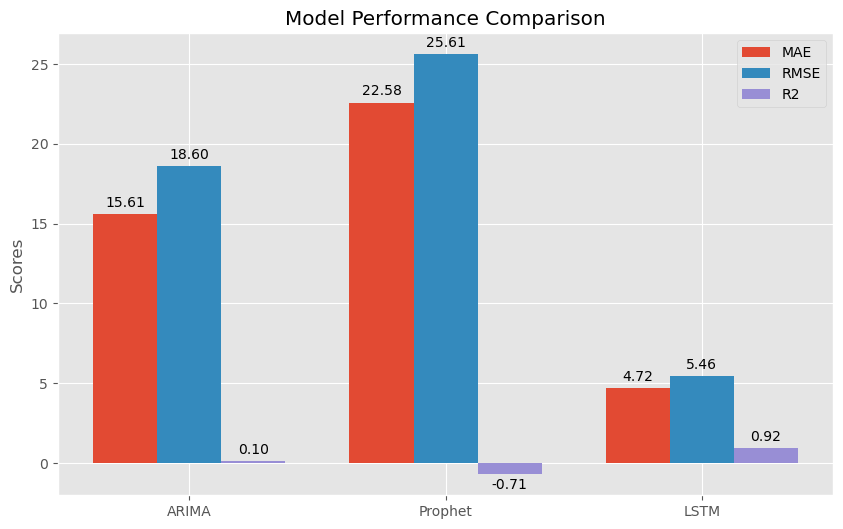

In [11]:
# Model Performance comparison
models = ['ARIMA', 'Prophet', 'LSTM']
mae_scores = [arima_mae, prophet_mae, lstm_mae]
rmse_scores = [arima_rmse, prophet_rmse, lstm_rmse]
r2_scores = [arima_r2, prophet_r2, lstm_r2]

x = np.arange(len(models))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting bars
bars1 = ax.bar(x - width, mae_scores, width, label='MAE')
bars2 = ax.bar(x, rmse_scores, width, label='RMSE')
bars3 = ax.bar(x + width, r2_scores, width, label='R2')

# Adding the metric values on top of each bar
ax.bar_label(bars1, fmt='%.2f', padding=3)
ax.bar_label(bars2, fmt='%.2f', padding=3)
ax.bar_label(bars3, fmt='%.2f', padding=3)

# Chart formatting
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.grid(True)
plt.show()

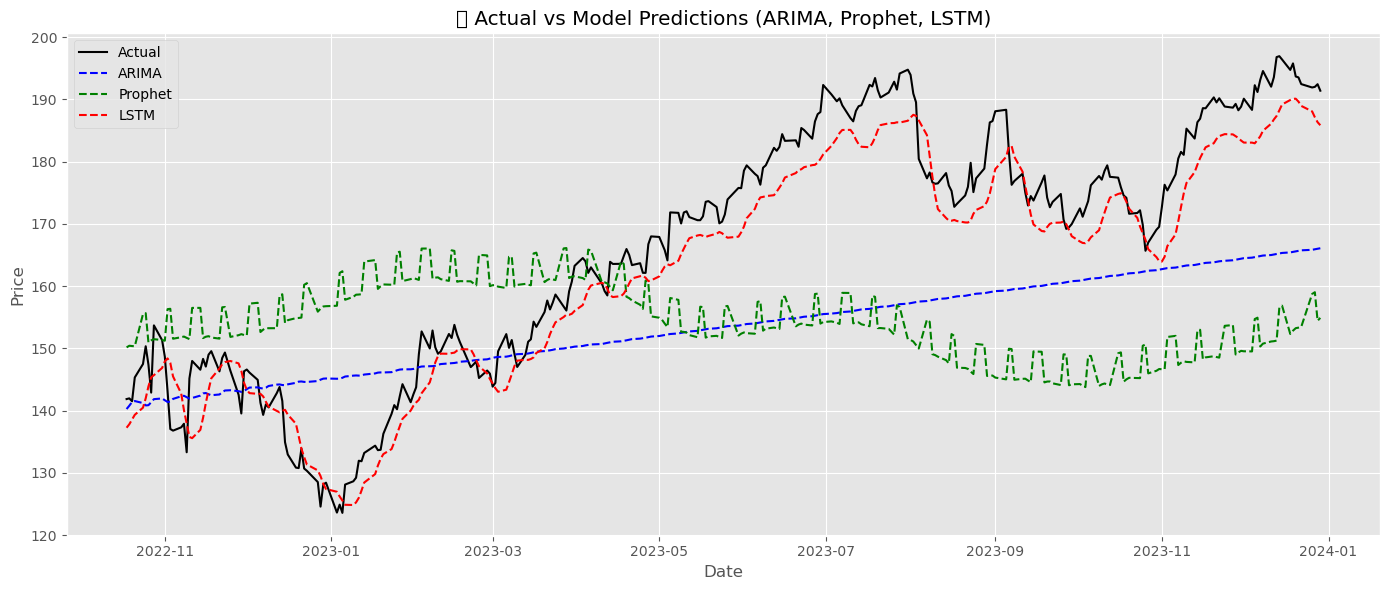

In [12]:
# Ensure all predictions and actuals are aligned to the same length for comparison
min_len = min(len(test['Close']), len(arima_preds), len(prophet_preds), len(actual_lstm), len(lstm_preds_rescaled))

# Trim all data to the same length
common_dates = test['Date'][:min_len]
actual_common = test['Close'].values[:min_len]
arima_common = np.ravel(arima_preds)[:min_len]
prophet_common = np.ravel(prophet_preds)[:min_len]
lstm_common = np.ravel(lstm_preds_rescaled)[:min_len]

# Plot Actual vs All Model Predictions
plt.figure(figsize=(14, 6))
plt.plot(common_dates, actual_common, label='Actual', color='black')
plt.plot(common_dates, arima_common, label='ARIMA', linestyle='--', color='blue')
plt.plot(common_dates, prophet_common, label='Prophet', linestyle='--', color='green')
plt.plot(common_dates, lstm_common, label='LSTM', linestyle='--', color='red')
plt.title("📊 Actual vs Model Predictions (ARIMA, Prophet, LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


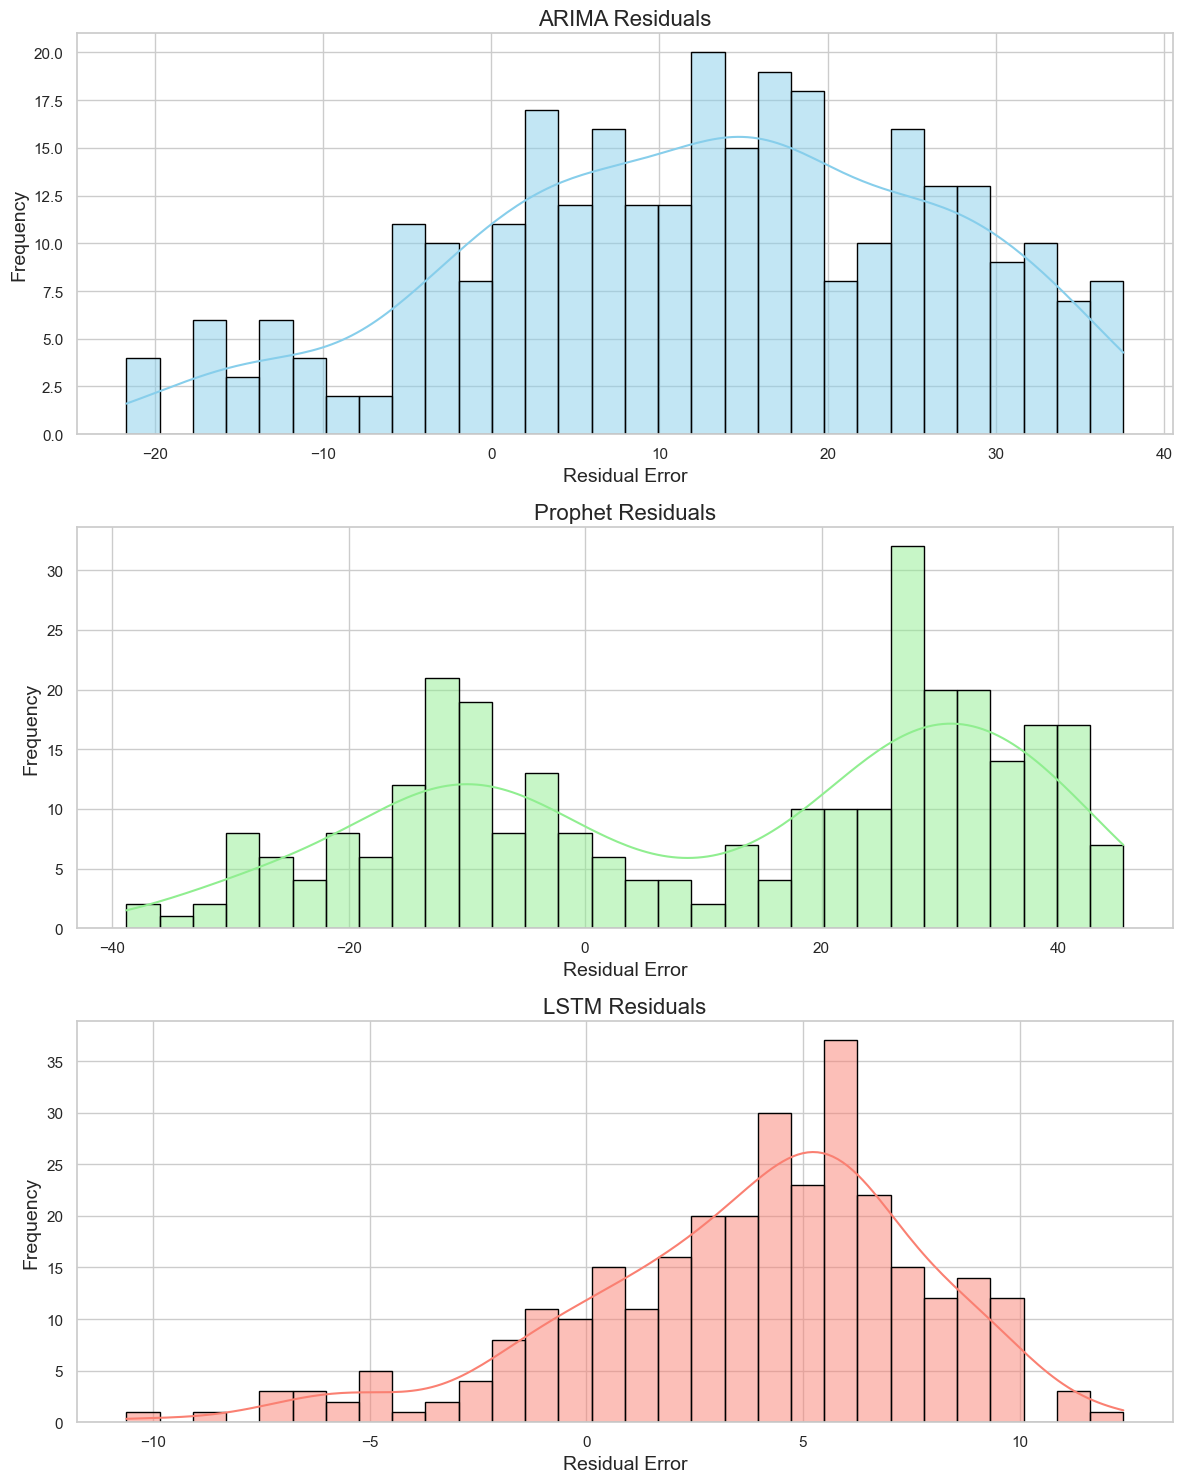

In [13]:
# Plotting Model Residuals
# Ensure predictions and actuals are 1D
arima_preds = np.ravel(arima_preds)
prophet_preds = np.ravel(prophet_preds)
lstm_preds_rescaled_flat = np.ravel(lstm_preds_rescaled)
test_close = np.ravel(test['Close'].values)

# Calculate residuals
residuals = {
    "ARIMA": test_close - arima_preds,
    "Prophet": test_close - prophet_preds,
    "LSTM": actual_lstm - lstm_preds_rescaled_flat
}


colors = {
    "ARIMA": "skyblue",
    "Prophet": "lightgreen",
    "LSTM": "salmon"
}


sns.set(style="whitegrid")

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 15))

for i, (model_name, res) in enumerate(residuals.items()):
    sns.histplot(res, kde=True, ax=axs[i], bins=30, 
                 color=colors[model_name], edgecolor="black")
    axs[i].set_title(f'{model_name} Residuals', fontsize=16)
    axs[i].set_xlabel('Residual Error', fontsize=14)
    axs[i].set_ylabel('Frequency', fontsize=14)
    axs[i].grid(True)

plt.tight_layout()
plt.show()